In [1]:
import os 
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter, FuncFormatter
from statsmodels.distributions.empirical_distribution import ECDF
import dataframe_image as dfi # for saving styled data frame print-out table as png

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
# set paths and create dirs 
base_dir = '../..'
data_dir = os.path.join(base_dir, 'data')
helper_dir = os.path.join(base_dir, 'helper')
output_dir = os.path.join(base_dir, 'output')
png_dir = os.path.join(output_dir, 'png')
csv_dir = os.path.join(output_dir, 'csv')
os.makedirs(png_dir, exist_ok=True)
os.makedirs(csv_dir, exist_ok=True)

In [3]:
# load helper functions
%run {helper_dir}/plot.py
%run {helper_dir}/mc_frequentist.py
%run {helper_dir}/rollup_daily_logrets.py

In [4]:
class Quantile:
    def __init__(self, q):
        self.q = q
    def __call__(self, x):
        return np.quantile(x.dropna(), self.q)

## Input

In [5]:
chain = 'Arbitrum'

In [6]:
reward_token = 'AVAX' if chain == 'Avalanche' else 'ETH'

In [7]:
data_fnames = os.listdir(os.path.join(data_dir, chain)) # names of all data files

# collect the names of the files for this analysis
fnames = dict()
for fname in data_fnames:
    if fname.startswith('Glp Price Comparison'):
        fnames['Glp Price Comparison'] = fname
fnames

{'Glp Price Comparison': 'Glp Price Comparison_2021-08-31_2022-07-13.csv'}

## Prep Data

In [8]:
# read data
df = (pd.read_csv(os.path.join(data_dir, chain, fnames['Glp Price Comparison']), 
                 index_col='Date', parse_dates=['Date'])
        .iloc[:-1, ] # drop the last row since it may not be a full day
        .loc[:, ['glpPrice', 'glpPlusFees']]
        .rename(columns={'glpPrice':'glp_price',
                         'glpPlusFees':'glp_plusfees_price',
                        })
     )
df.tail()

glp_price  glp_plusfees_price
Date                                     
2022-07-08     0.8226              1.1281
2022-07-09     0.8179              1.1235
2022-07-10     0.8039              1.1100
2022-07-11     0.7854              1.0921
2022-07-12     0.7713              1.0783

## Frequentist Monte Carlo Simulation of Future Returns of GLP

In [9]:
# input
future_days = 120 # how many days in the future (from the last day of observation) do you want to simulate?
n_sim = 1000      # how many times/paths do you want to run? (or the number of samples to draw for each future day)
start_date = df.index[0]     # investment start date, can use a date string, for example, '2022-06-15'

In [10]:
# calc historical daily log returns of GLP
logret_his = np.log(df.glp_plusfees_price / df.glp_plusfees_price.shift(1)).dropna()
logret_his.name = 'logret'
logret_his.index.name = 'date'

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 322.965] [loc=-0.000 scale=0.017]
[distfit] >[expon     ] [0.00 sec] [RSS: 4589.01] [loc=-0.110 scale=0.109]
[distfit] >[pareto    ] [0.09 sec] [RSS: 4639.76] [loc=-3179406.244 scale=3179406.134]
[distfit] >[dweibull  ] [0.01 sec] [RSS: 103.954] [loc=-0.000 scale=0.012]
[distfit] >[t         ] [0.04 sec] [RSS: 54.4319] [loc=0.000 scale=0.012]
[distfit] >[genextreme] [0.15 sec] [RSS: 5174.16] [loc=-0.005 scale=0.122]
[distfit] >[gamma     ] [0.06 sec] [RSS: 5009.12] [loc=-0.110 scale=1.991]
[distfit] >[lognorm   ] [0.14 sec] [RSS: 320.759] [loc=-6.860 scale=6.860]
[distfit] >[beta      ] [0.11 sec] [RSS: 308.198] [loc=-5359.434 scale=5359.644]
[distfit] >[uniform   ] [0.00 sec] [RSS: 3855.57] [loc=-0.110 scale=0.192]
[distfit] >[loggamma  ] [0.03 sec] [RSS: 292.85] [loc=-0.305 scale=0.092]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..


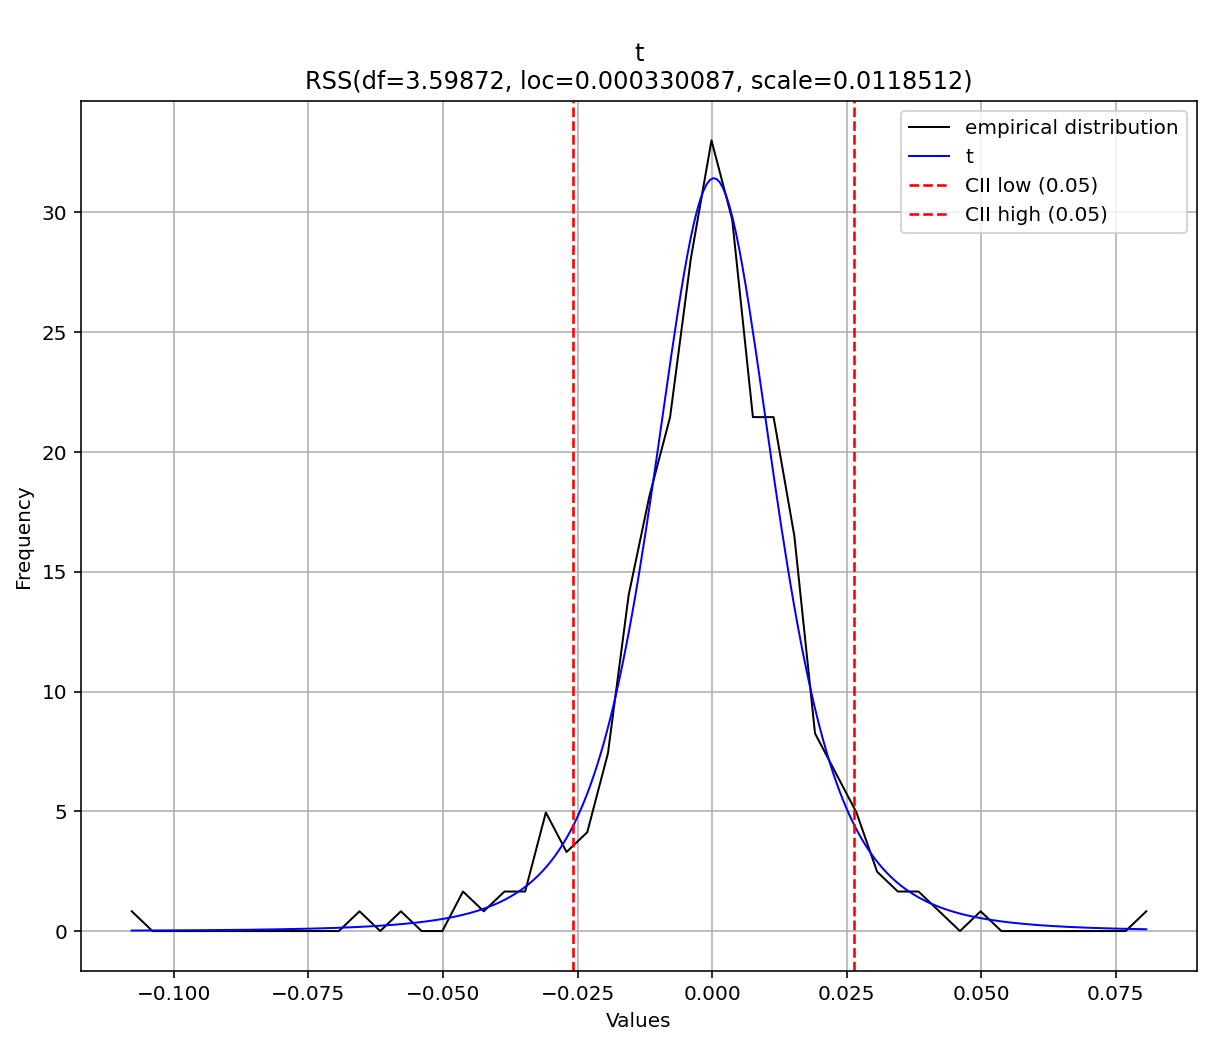

In [11]:
df_fut = mc_frequentist(logret_his, n_fut=future_days, n_iter=n_sim, show_plot=True)

In [12]:
# give meaning to the index of future log returns frame
df_fut.index = logret_his.index[-1] + pd.to_timedelta(df_fut.index.values+1, 'd')
df_fut.head()

iter1   iter2   iter3   iter4   iter5   iter6   iter7  ...  \
2022-07-13  0.0115 -0.0290  0.0042 -0.0344 -0.0015 -0.0071 -0.0035  ...   
2022-07-14 -0.0008 -0.0069 -0.0102  0.0062 -0.0415  0.0017 -0.0303  ...   
2022-07-15  0.0218 -0.0018 -0.0145  0.0129  0.0064 -0.0120  0.0235  ...   
2022-07-16  0.0040 -0.0003  0.0052 -0.0024  0.0148 -0.0305  0.0167  ...   
2022-07-17  0.0033  0.0190 -0.0084  0.0223 -0.0135 -0.0014  0.0077  ...   

            iter994  iter995  iter996  iter997  iter998  iter999  iter1000  
2022-07-13   0.0025  -0.0046  -0.0062   0.0105   0.0285  -0.0158   -0.0115  
2022-07-14   0.0179   0.0181   0.0282   0.0055  -0.0043  -0.0408    0.0134  
2022-07-15   0.0464   0.0215  -0.0108   0.0098  -0.0116  -0.0048    0.0094  
2022-07-16  -0.0074   0.0050   0.0098   0.0105  -0.0001   0.0006    0.0189  
2022-07-17   0.0196  -0.0013  -0.0064   0.0742  -0.0154  -0.0173    0.0097  

[5 rows x 1000 columns]

In [13]:
# change to long format
logret_fut = df_fut.stack()
# name the series and the levels of its index for ease of downstream process
logret_fut.name = logret_his.name
logret_fut.index.names = ['date', 'iter_no']
logret_fut

date        iter_no 
2022-07-13  iter1       0.0115
            iter2      -0.0290
            iter3       0.0042
            iter4      -0.0344
            iter5      -0.0015
                         ...  
2022-11-09  iter996    -0.0124
            iter997    -0.0042
            iter998    -0.0182
            iter999    -0.0113
            iter1000   -0.0008
Name: logret, Length: 120000, dtype: float64

In [14]:
# give multilevel index to logret_his to be consistent with logret_fut and because
# rollup_daily_logrets() downstream expects such a multilevel index.
# since there are no runs of simulation for historical data, we'll simply use 'iter0' for the `iter_no` level.
new_index = list(zip(logret_his.index, ['iter0']*len(logret_his)))
logret_his.index = pd.MultiIndex.from_tuples(new_index, names=(logret_his.index.name, 'iter_no'))
logret_his

date        iter_no
2021-09-01  iter0      0.0826
2021-09-02  iter0     -0.0031
2021-09-03  iter0      0.0149
2021-09-04  iter0      0.0013
2021-09-05  iter0      0.0093
                        ...  
2022-07-08  iter0      0.0008
2022-07-09  iter0     -0.0040
2022-07-10  iter0     -0.0122
2022-07-11  iter0     -0.0162
2022-07-12  iter0     -0.0127
Name: logret, Length: 315, dtype: float64

In [15]:
last_day = logret_his.index.get_level_values('date')[-1]
assert pd.to_datetime(start_date) <= last_day # can't start after the last day of available historical returns

# select historical daily log returns after investment start data
print("Investment started on", start_date, '\n')
chosen_logret_his = logret_his.loc[pd.to_datetime(start_date) + pd.Timedelta(days=1):]
print(chosen_logret_his.head())

Investment started on 2021-08-31 00:00:00 

date        iter_no
2021-09-01  iter0      0.0826
2021-09-02  iter0     -0.0031
2021-09-03  iter0      0.0149
2021-09-04  iter0      0.0013
2021-09-05  iter0      0.0093
Name: logret, dtype: float64


In [16]:
# roll up to weekly and monthly levels
dd_his = rollup_daily_logrets(chosen_logret_his)
dd_fut = rollup_daily_logrets(logret_fut)

## The Growth Paths of $10,000 in GLP

In [17]:
# user inputs
init_investment = 10_000 # dollars
time_freq = 'daily' # 'daily', 'weekly', or 'monthly'

In [18]:
# choose data based on user input
logrets_his = dd_his[time_freq]
logrets_fut = dd_fut[time_freq]

if time_freq == 'daily':
    time_freq_col = 'date'
elif time_freq == 'weekly':
    time_freq_col = 'week'    
else: # runs monthly by default
    time_freq_col = 'month'

In [19]:
# calc value of investment at each past time index
values_his = init_investment * logrets_his.cumsum().apply(np.exp)
values_his.name = 'value'
values_his = values_his.to_frame()
values_his

value
iter_no date                  
iter0   2021-09-01 10,861.1156
        2021-09-02 10,827.2035
        2021-09-03 10,989.3746
        2021-09-04 11,004.1827
        2021-09-05 11,107.0650
...                        ...
        2022-07-08  9,451.3662
        2022-07-09  9,413.5628
        2022-07-10  9,299.8205
        2022-07-11  9,150.0450
        2022-07-12  9,034.3388

[315 rows x 1 columns]

In [20]:
# calc value of investment at each future time index
value_now = values_his.value[-1]
values_fut = (
    logrets_fut.reset_index()
        .rename(columns={'level_0':'iter_no'})
        .set_index(['iter_no', time_freq_col])
        .sort_index()
        .groupby('iter_no')
        .logret.cumsum().apply(np.exp)
    ) * value_now
values_fut.name = 'value'
values_fut = values_fut.to_frame()
values_fut

value
iter_no date                  
iter1   2022-07-13  9,138.8366
        2022-07-14  9,131.8191
        2022-07-15  9,332.7221
        2022-07-16  9,369.8471
        2022-07-17  9,400.6720
...                        ...
iter999 2022-11-05 10,822.1576
        2022-11-06 11,024.6637
        2022-11-07 11,215.8092
        2022-11-08 11,227.6037
        2022-11-09 11,101.6816

[120000 rows x 1 columns]

In [21]:
# create a row of data for initial investment 
time_delta_val = pd.Timedelta(days=1) if time_freq == 'daily' else 1 
t0 = values_his.index.get_level_values(time_freq_col)[0] - time_delta_val 
# print(t0)
idx = pd.MultiIndex.from_arrays([['iter0'], [t0]], names=('iter_no', time_freq_col)) 
value_genesis = pd.DataFrame({'value': init_investment}, index=idx)
value_genesis

value
iter_no date             
iter0   2021-08-31  10000

In [22]:
# stack 
value_growth_paths = pd.concat([value_genesis, values_his, values_fut]) 
value_growth_paths

value
iter_no date                  
iter0   2021-08-31 10,000.0000
        2021-09-01 10,861.1156
        2021-09-02 10,827.2035
        2021-09-03 10,989.3746
        2021-09-04 11,004.1827
...                        ...
iter999 2022-11-05 10,822.1576
        2022-11-06 11,024.6637
        2022-11-07 11,215.8092
        2022-11-08 11,227.6037
        2022-11-09 11,101.6816

[120316 rows x 1 columns]

In [23]:
# reformat and prep for plot
value_growth_paths = value_growth_paths.reset_index()
value_growth_paths['group'] = np.where(value_growth_paths.iter_no == 'iter0', 'historical', 'predicted')
value_growth_paths.head()

iter_no       date       value       group
0   iter0 2021-08-31 10,000.0000  historical
1   iter0 2021-09-01 10,861.1156  historical
2   iter0 2021-09-02 10,827.2035  historical
3   iter0 2021-09-03 10,989.3746  historical
4   iter0 2021-09-04 11,004.1827  historical

In [24]:
# calc the mean and 95% CI of investment value at each time
value_means_cis = (value_growth_paths.query("iter_no != 'iter0'") # iter0 iff historical
                       .groupby(time_freq_col)
                       .agg(value_m = ('value', np.mean),
                            value_l = ('value', Quantile(.025)),
                            value_u = ('value', Quantile(.975)))
                  ).reset_index()
value_means_cis

date    value_m    value_l     value_u
0   2022-07-13 9,028.4964 8,737.2952  9,318.4165
1   2022-07-14 9,037.1052 8,581.1970  9,502.2869
2   2022-07-15 9,033.1084 8,445.0565  9,584.2685
3   2022-07-16 9,039.7222 8,411.9506  9,681.1976
4   2022-07-17 9,052.4891 8,379.3390  9,882.0162
..         ...        ...        ...         ...
115 2022-11-05 9,534.5747 6,373.3931 13,627.1603
116 2022-11-06 9,546.1974 6,425.5129 13,717.8609
117 2022-11-07 9,552.6381 6,375.7098 13,762.5684
118 2022-11-08 9,564.5887 6,363.5089 13,958.0230
119 2022-11-09 9,573.8613 6,368.7533 14,049.9036

[120 rows x 4 columns]

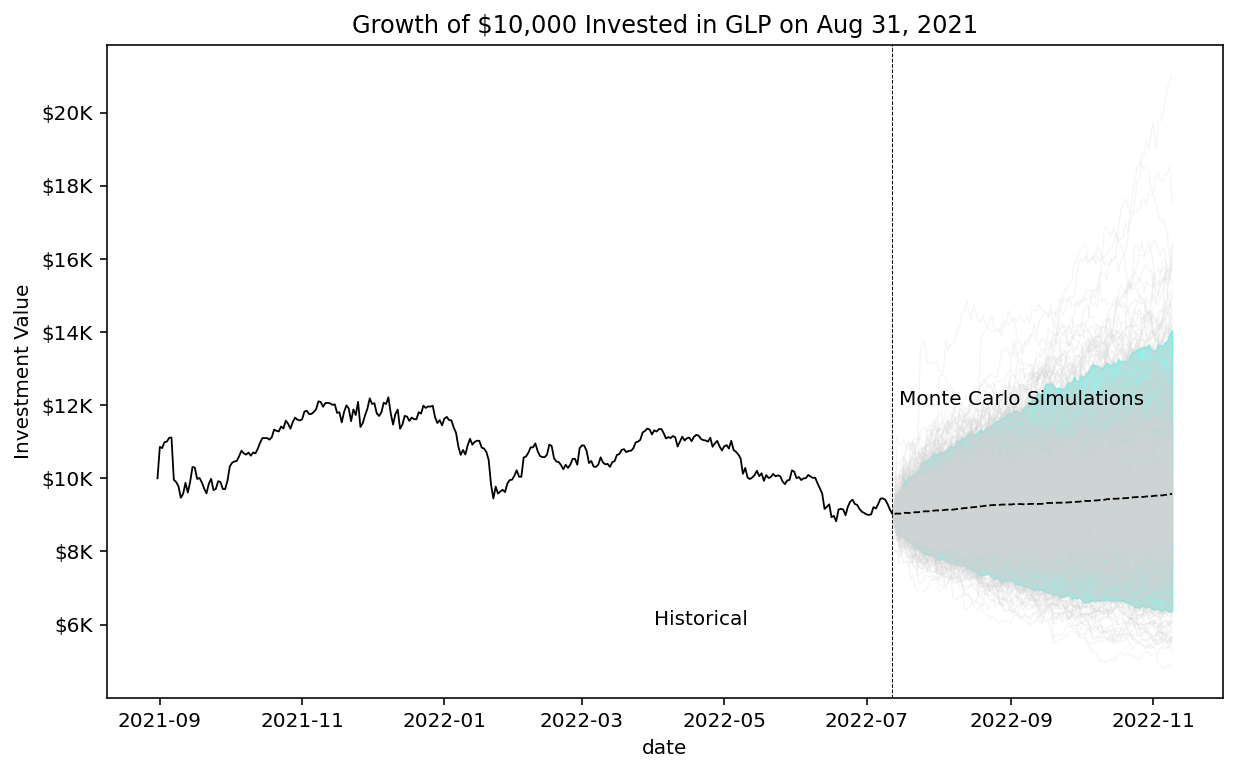

In [25]:
fig, ax = plt.subplots(1, 1)
plt.title("Growth of ${:,} Invested in GLP on {}".format(init_investment, start_date.strftime('%b %d, %Y')))
plt.xlabel(time_freq_col)
plt.ylabel("Investment Value")

# plot historical value path
value_growth_his = value_growth_paths.query("iter_no=='iter0'")
plt.plot(time_freq_col, 'value', data=value_growth_his, color='black', alpha=1, linewidth=0.9)

# add a verticle line at the last day of historical observations; from this point onward (to the right), it's all forecasts
plt.axvline(x=last_day, linewidth=0.5, color='black', linestyle='--')

# add simulated paths for the future
for i in range(1, n_sim+1):
    da = value_growth_paths[value_growth_paths.iter_no == 'iter{}'.format(i)]
    plt.plot(time_freq_col, 'value', data=da, color='lightgray', alpha=0.2, linewidth=0.7)

# add the mean path of those simulated future paths
plt.plot(time_freq_col, 'value_m', data=value_means_cis, color='black', alpha=1, linewidth=0.9, linestyle='--')

# add the 95% confidence band of those simulated future paths
plt.fill_between(time_freq_col, y1='value_u', y2='value_l', data=value_means_cis, 
                 color="#4aeae044", linewidth=0.9, alpha=0.6)

# format y-axis to dollar currency
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax.yaxis.set_major_formatter(formatter)

# add text
plt.text(pd.to_datetime('2022-04-01'), 6000, 'Historical')
plt.text(pd.to_datetime('2022-07-15'), 12000, 'Monte Carlo Simulations')

# save
fname = 'glp_investment_growth_since_{}_mc_vanilla.png'.format(start_date.strftime('%b %d, %Y'))
plt.savefig(os.path.join(png_dir, chain, fname), dpi=300);

## Some statistics on the simulated future returns

In [26]:
# calculate cumulative returns for each iteration
cumu_rets_fut = np.exp(logrets_fut.groupby('iter_no').cumsum()) - 1
cumu_rets_fut.name = 'cumu_ret'
cumu_rets_fut.head()

iter_no  date      
iter1    2022-07-13   0.0116
         2022-07-14   0.0108
         2022-07-15   0.0330
         2022-07-16   0.0371
         2022-07-17   0.0405
Name: cumu_ret, dtype: float64

In [27]:
# only analyze cummulative returns in x days, where x is defined as
x_days = [7, 30, 60, 90, 120] # days
fut_start_date = cumu_rets_fut.index.get_level_values('date').min()
fut_end_dates = [fut_start_date + pd.Timedelta(days=d-1) for d in x_days]
chosen_cumu_rets_fut = cumu_rets_fut.loc[(slice(None), fut_end_dates)]
chosen_cumu_rets_fut.head() 

iter_no  date      
iter1    2022-07-19   0.0784
         2022-08-11   0.1645
         2022-09-10   0.1823
         2022-10-10   0.2101
         2022-11-09   0.0143
Name: cumu_ret, dtype: float64

In [28]:
newindex = ['in {} days'.format(d) for d in x_days]

In [29]:
# calc expected return percentiles         
ret_percentiles = (chosen_cumu_rets_fut
                       .groupby('date')
                       .agg(percentile_10th = Quantile(.1),
                            percentile_25th = Quantile(.25),
                            percentile_50th = Quantile(.5),
                            percentile_75th = Quantile(.75),
                            percentile_90th = Quantile(.9),)
                  )
ret_percentiles.index = newindex
ret_percentiles = ret_percentiles.style.format('{:.2%}'.format)
dfi.export(ret_percentiles, os.path.join(png_dir, chain, 'glp_simret_percentiles.png'))
ret_percentiles

[0713/103227.383417:INFO:headless_shell.cc(660)] Written to file /var/folders/qq/v47zfw7s1kn38gw67q4v194r0000gn/T/tmpdd2obw7x/temp.png.


In [30]:
# calc return probabilities 
target_rets = np.array([0, 10, 25, 50, 100]) / 100
ret_probs = pd.concat((chosen_cumu_rets_fut.groupby('date').apply(lambda x: 1 - ECDF(x)(target_ret)) for target_ret in target_rets), axis=1)
ret_probs.index = newindex
ret_probs.columns = ["Return > {:.0%}".format(r) for r in target_rets]
ret_probs = ret_probs.style.format('{:.2%}'.format)
dfi.export(ret_probs, os.path.join(png_dir, chain, 'glp_simret_probs.png'))
ret_probs

[0713/103228.776888:INFO:headless_shell.cc(660)] Written to file /var/folders/qq/v47zfw7s1kn38gw67q4v194r0000gn/T/tmpo05xg1_6/temp.png.
